In [1]:
from __future__ import division, print_function # python3 compatibilty
import pymc3 as pm
import numpy
import pandas as pd
import numpy as np                  # import numpy
from time import time               # use for timing functions
import matplotlib.gridspec as gridspec
from scipy import stats
#from matplotlib import pyplot as pl # import pyplot from matplotlib
import matplotlib.pyplot as plt

rcparams = {}
rcparams['text.usetex'] = True
rcparams['axes.linewidth'] = 0.7
rcparams['font.family'] = 'sans-serif'
rcparams['font.size'] = 22
plt.rcParams['mathtext.fontset'] = 'dejavuserif'


# functions for plotting posteriors
import scipy
import corner
from scipy.stats import gaussian_kde
import os

In [2]:
#read the data
os.chdir('/Users/krishna/Documents/phd_work/SNe_data_analy/checks')

df = pd.read_csv('data_shoes.csv')
#df = df.drop([4, 16])
SN_ceph = df['SN_name'].to_numpy()
host = df['host'].to_numpy()
mu_ceph = df['mu_ceph'].to_numpy()
e_mu = df['e_mu'].to_numpy()
bmax = df['Bmax'].to_numpy()
ebmax = df['eBmax'].to_numpy()
vmax = df['Vmax'].to_numpy()
evmax = df['eVmax'].to_numpy()
st = df['stretch'].to_numpy()
est = df['err_stretch'].to_numpy()
color = df['color'].to_numpy()
ecolor = df ['e_color'].to_numpy()
log_M = df['log_Mass'].to_numpy()
e_logM = df['e_logMass'].to_numpy()

#display(df)
print(len(SN_ceph))

#Lowzhflow_maxmodel_st
dff = pd.read_csv('data_lowz_HM.csv')
#df_cos = pd.read_csv('data_lowz_HM.csv')
df_cos = dff.loc[(dff['redshift'] > 0.02) & (dff['redshift'] < 0.15)]
SN_name = df_cos['SN_name'].to_numpy()
Bmax = df_cos['Bmax'].to_numpy()
eBmax = df_cos['eBmax'].to_numpy()
Vmax = df_cos['Vmax'].to_numpy()
eVmax = df_cos['eVmax'].to_numpy()
s = df_cos['stretch'].to_numpy()
es = df_cos['err_stretch'].to_numpy()
ebv = df_cos['color'].to_numpy()
eEBV = df_cos['e_color'].to_numpy()
logM = df_cos['log_Mass'].to_numpy()
elogM = df_cos['e_logMass'].to_numpy()
z = df_cos['redshift'].to_numpy()

print(len(SN_name))

19
96


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ext, sigma_SN, H0, alpha, R, P1, P0]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [01:24<00:00, 331.77draws/s]


Time taken to run 'PyMC3' is 98.84646916389465 seconds
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
P0       -19.159  0.047 -19.245  -19.068      0.001    0.000    6503.0   
P1        -0.943  0.115  -1.150   -0.719      0.001    0.001   13817.0   
R          2.146  0.163   1.839    2.454      0.002    0.001   11024.0   
alpha      0.036  0.038  -0.036    0.108      0.000    0.000   10628.0   
H0        73.765  1.969  70.059   77.442      0.026    0.018    5955.0   
sigma_SN   0.172  0.043   0.098    0.252      0.000    0.000   10106.0   
ext        0.144  0.016   0.115    0.174      0.000    0.000   11325.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
P0         6503.0    6693.0    5508.0    1.0  
P1        13459.0   13853.0    8230.0    1.0  
R         11024.0   10913.0    7762.0    1.0  
alpha      7991.0   10659.0    8330.0    1.0  
H0         5872.0    6063.0    4335.0    1.0  
sigma_SN   9447.0   10165.0    7940.0    1.0  
ext       11325.0   112

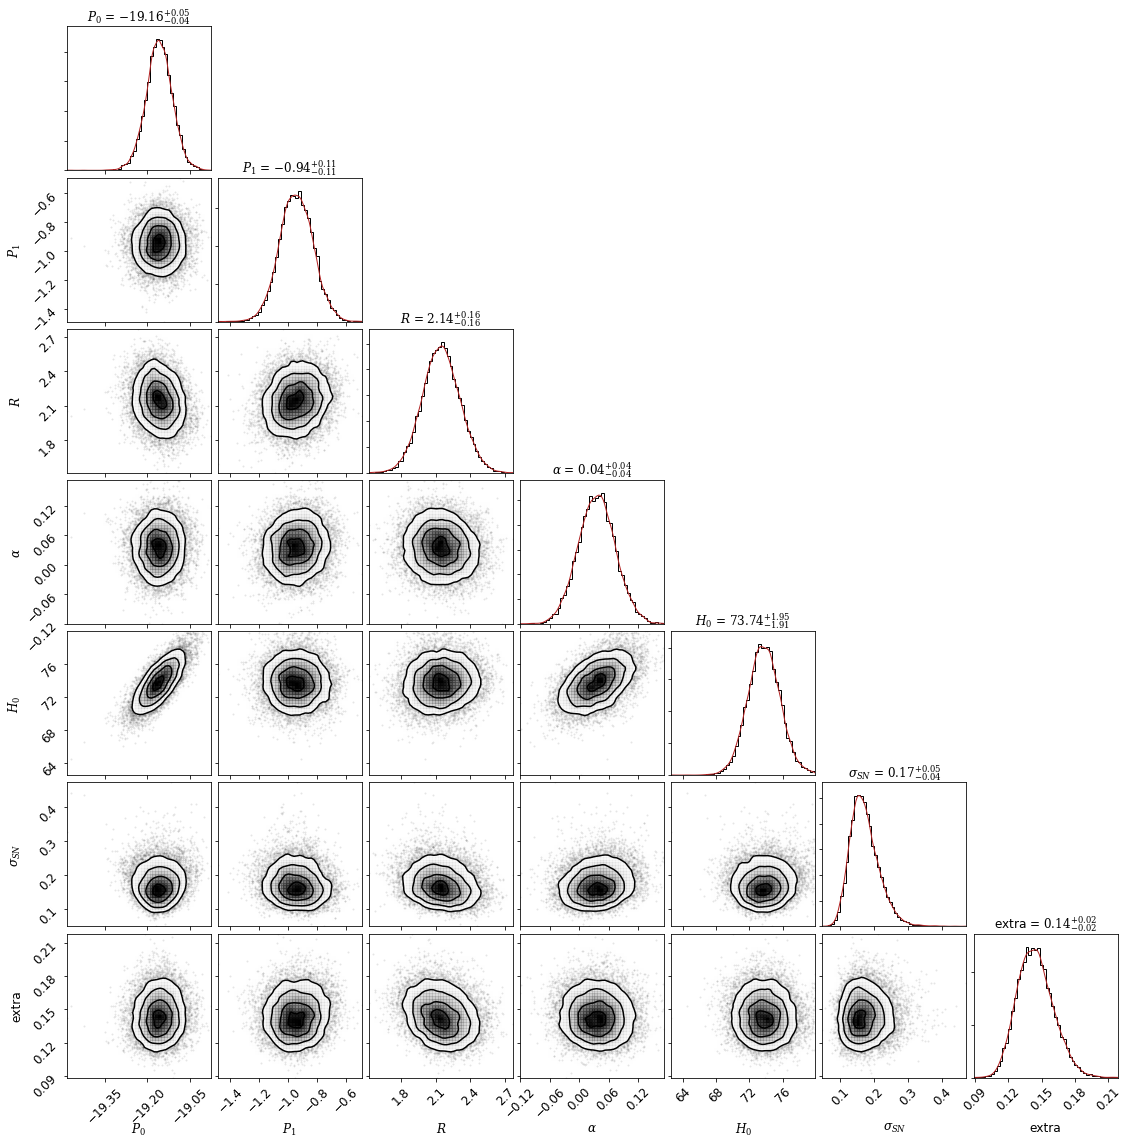

In [12]:
with pm.Model():
    P_0 = pm.Uniform('P0', lower = -30, upper = 30)
    P_1 = pm.Uniform('P1', lower = -5, upper = 5)
    R = pm.Uniform('R', lower = 0, upper = 15)
    alpha = pm.Uniform('alpha', lower = -5, upper = 5)
    H0 = pm.Uniform('H0', lower = 60, upper = 80)
    sigma_SN = pm.HalfCauchy('sigma_SN', 5)
    ext = pm.HalfCauchy('ext', 5)


    c = 299792.458
    q0 = -0.55
    j0 = 1
    
    
    mu0 = P_0 + P_1*(st-1) + R*(color) + alpha*(log_M - 10) + mu_ceph
    
    mu1 = P_0 + P_1*(s-1) + R*(ebv) + alpha*(logM - 10) + 5*np.log10((c*z/H0)*(1 + 1/2*(1- q0)*z - 1/6*(1- q0 - 3*q0**2 + j0)*z**2)) + 25
    
    
    sigma0 = np.sqrt(ebmax ** 2 + sigma_SN**2 + e_mu**2 + (P_1*est)**2 + (alpha*e_logM)**2 +
                    R**2*(ebmax**2 + evmax**2) - 2*R*ebmax**2 + 0.4*e_mu**2)
    
    sigma1 = np.sqrt(eBmax ** 2 + ext**2 + (P_1*es)**2 + (alpha*elogM)**2 +
                    R**2*(eBmax**2 + eVmax**2) - 2*R*eBmax**2)
    
    results0 = pm.Normal('results0', mu0, sigma0, observed = bmax)
    results1 = pm.Normal('results1', mu1, sigma1, observed = Bmax)
    # This line is constructing the likelihood for me taking mu, model, and sigma
    
    
    Nsamples = 3000  # final number of samples
    Ntune = 4000  # number of tuning samples

    # perform sampling
    t0 = time()
    trace = pm.sample(Nsamples, tune=Ntune, discard_tuned_samples=True, cores=4,target_accept=0.9);  # perform sampling
    t1 = time()
    timepymc3 = (t1-t0)
    print("Time taken to run 'PyMC3' is {} seconds".format(timepymc3))
    plt.rcParams.update({'font.size': 12})
    #fig = plt.gcf() # to get the current figure...
    #fig.savefig("MCMC_trace_Goldsample.png")
    print(pm.summary(trace))
#     print(pm.trace_cov(trace))
#     cov = pm.trace_cov(trace)
#     sd = np.sqrt(np.diag(cov))
#     corr = np.diag(sd**-1).dot(cov.dot(np.diag(sd**-1)))
#     print(sd)
#     print(corr)

#------------------------------------------------------------------------
#Function to plot corner plots
    
def plotposts(samples):    
    fig = corner.corner(samples, bins = 50, labels=[r'$P_0$', r'$P_1$', r'$R$', r'$\alpha$', r'$H_0$', r'$\sigma_{SN}$', r'extra'], 
                        color = 'black',
                        show_titles=True,
                        hist_kwargs={'density': True}, smooth = True, title_kwargs={"fontsize": 12},
                        label_kwargs={"fontsize": 12})


        # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 8, 16, 24, 32, 40, 48], samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick', lw = 1)
    fig = plt.gcf() # to get the current figure...
    #fig.savefig("SBF_TrippHM_corner.pdf",dpi = 500, bbox_inches='tight', pad_inches=0.2)

#plt.rcParams.update({'font.size': 16}) # reset the font size
samples_pymc3 = np.vstack((trace['P0'], trace['P1'], trace['R'], trace['alpha'], trace['H0'], trace['sigma_SN'], trace['ext'])).T
plotposts(samples_pymc3)
# corr = np.diag(sd**-1).dot(cov.dot(np.diag(sd**-1)))
# print(corr)  

In [13]:
#fit params
means = pm.summary(trace)['mean'].values
sds = pm.summary(trace)['sd'].values
p0, ep0 = means[0], sds[0]
p1, ep1 = means[1], sds[1]
r, er = means[2], sds[2]
alpha, ealpha = means[3], sds[4]
sig = means[5]

In [21]:
#calculate mu
def mu_HM(st, mB, mV, mass, P0, P1, R, alp, est, emB, eEBV, emass, eP0, eP1 , eR, ealp, dSN):   #alp = alpha

    mu_i = mB - P0 - P1*(st - 1.) - R*(mB-mV)- alp*(mass -11)  # calculate the distance modulus

    dmu_i = np.sqrt(emB ** 2 + eP0 ** 2 + ((st - 1.) * eP1) ** 2 + (P1*est)**2 + (eR * (mB - mV)) ** 2 
                + dSN ** 2 + (R*eEBV)**2 + (alp*emass)**2 + (ealp*(mass-11))**2) # calculate the error on \mu

    return mu_i, dmu_i

mu_shoes =[]
dmu =[]

for i in range(len(Bmax)):
    mu, sig_mu = mu_HM(s[i],Bmax[i], Vmax[i], logM[i], p0, p1, r, alpha, es[i], eBmax[i], eEBV[i], elogM[i],
                       ep0, ep1, er, ealpha, sig)
    mu_shoes.append(mu)
    dmu.append(sig_mu)
    #mu_SBF = [round(elem, 3) for elem in mu_SBF]
    #sig_muSBF = [round(elem, 3) for elem in sig_muSBF]

dict = {'name': SN_name, 'mu': mu_shoes, 'err_mu': dmu}     
dist = pd.DataFrame(dict)
#dist.to_csv(os.getcwd()+'/Hierchichal_analysis/SHOES_cosmo_linHM.csv')

In [ ]:
# R2 score and RMSE of the models
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
from sklearn.metrics import mean_squared_error, r2_score
#extracting the fit parameters
P_00 = np.mean(samples_pymc3[:,0])     
eP_00 = np.std(samples_pymc3[:,0])     #var names just temporary
P_11 = np.mean(samples_pymc3[:,1])     
eP_11 = np.std(samples_pymc3[:,1])      # standard deviation of b_BBV samples
R0 = np.mean(samples_pymc3[:,2])
eR0 = np.std(samples_pymc3[:,2])
alpha0 = np.mean(samples_pymc3[:,3])
ealpha0 = np.std(samples_pymc3[:,3])
sigSN0 = np.mean(samples_pymc3[:,5])

#plot the relation
def bestfit(p0,p1,st):
    return p0 + p1*(st-1)

x = np.linspace(0., 1.5, 100)
fit1 = bestfit(P_00, P_11, x)
pred = bestfit(P_00, P_11, st)

Mb = []
Mb_err = []
for i in range(len(bmax)):
    M =  bmax[i] - mu_ceph[i] - R0*(color[i]) - alpha0*(log_M[i] - 11)
    dM = np.sqrt(ebmax[i] ** 2 + e_mu[i]**2 + (R0*ecolor[i])**2 + (eR0*color[i])**2 + (ealpha0*(log_M[i] - 11))**2)
    Mb.append(M)
    Mb_err.append(dM)
    
    
rcparams['text.usetex'] = True
rcparams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif' 


#fig1 = plt.figure(figsize=(8,6))  

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22,7))
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.tick_params(axis='both',direction='in',labelsize=16)
ax1.xaxis.set_tick_params(which='major',width=1.5,length=7.5)
ax1.xaxis.set_tick_params(which='minor',width=1.5,length=4.5)
ax1.yaxis.set_tick_params(which='major',width=1.5,length=7.5)
ax1.yaxis.set_tick_params(which='minor',width=1.5,length=4.5)
ax1.spines['top'].set_linewidth(1.5)
ax1.spines['right'].set_linewidth(1.5)
ax1.spines['bottom'].set_linewidth(1.5)
ax1.spines['left'].set_linewidth(1.5)
ax1.xaxis.set_label_coords(0.5, -0.06)
ax1.tick_params(axis='both',direction='in',which='both')
plt.rc('font', family='serif')

ax1.errorbar(st , Mb , yerr = Mb_err, xerr = est, fmt = 'o', mfc = '#d73027', mec = '#d73027', ecolor = '#d73027',
             ms = 10, lw = 1.2, capsize = 5)
ax1.plot(x , fit1, color = 'black', lw = 1.8)
ax1.set_xlabel(r"$s_{BV}$", fontfamily = 'serif', fontsize = 18) 
ax1.set_ylabel(r"$m_B - \mu_{SBF} - R(m_B - m_V) - \alpha(\log M-11)$", fontfamily = 'serif', fontsize = 16)
ax1.invert_xaxis()
ax1.set_ylim(-16, -21.5)

print("Mean squared error_st: %.2f" % mean_squared_error(Mb,pred))
print("R2 Score_st: %.2f" % r2_score(Mb,pred))

def colorfit(p0 , R, col):
    return p0 + R*col

col = np.linspace(-0.2, 0.8, 100)
fit2 = colorfit(P_00, R0, col)
pred2 = colorfit(P_00, R0, color)

Mcol = []
Mcol_err = []
for i in range(len(bmax)):
    M = bmax[i] - mu_ceph[i] - P_11*(st[i] - 1) - alpha0*(log_M[i] - 11)
    dM = np.sqrt(ebmax[i]**2 + e_mu[i]**2 + (P_11*est[i])**2 + (eP_11*(st[i]-1))**2 + (ealpha0*(log_M[i] - 11))**2)
    Mcol.append(M)
    Mcol_err.append(dM)

ax2.tick_params(axis='both',direction='in',labelsize=16)
ax2.xaxis.set_tick_params(which='major',width=1.5,length=7.5)
ax2.xaxis.set_tick_params(which='minor',width=1.5,length=4.5)
ax2.yaxis.set_tick_params(which='major',width=1.5,length=7.5)
ax2.yaxis.set_tick_params(which='minor',width=1.5,length=4.5)
ax2.spines['top'].set_linewidth(1.5)
ax2.spines['right'].set_linewidth(1.5)
ax2.spines['bottom'].set_linewidth(1.5)
ax2.spines['left'].set_linewidth(1.5)
ax2.xaxis.set_label_coords(0.5, -0.06)
ax2.tick_params(axis='both',direction='in',which='both')
plt.rc('font', family='serif')

ax2.errorbar(color , Mcol, yerr = Mcol_err , xerr = ecolor, fmt = 'o', mfc = '#d73027', mec = '#d73027', ecolor = '#d73027',
             ms = 10, lw = 1.2, capsize = 5)
ax2.plot(col, fit2, color='black', lw = 1.8)
ax2.set_xlabel(r"$(m_B-m_V)$", fontfamily = 'serif', fontsize = 18) 
ax2.set_ylabel(r"$m_B - \mu_{SBF} - P^1(s_{BV} - 1)-\alpha(\log M-11)$", fontfamily = 'serif', fontsize = 16)
ax2.set_ylim(-16, -21.5)

print("Mean squared error_color: %.2f" % mean_squared_error(Mcol,pred2))
print("R2 Score_color: %.2f" % r2_score(Mcol,pred2))



def massfit(p0, a, logm):
    return p0 + a*(logm - 11)

logmass = np.linspace(8, 12, 100)
fit3 = massfit(P_00, alpha0, logmass)
pred3 = massfit(P_00, alpha0, log_M)

Mmass = []
Mmass_err = []
for i in range(len(bmax)):
    M = bmax[i] - mu_ceph[i] - P_11*(st[i] - 1) - R0*(color[i])
    dM = np.sqrt(ebmax[i]**2 + e_mu[i]**2 + (P_11*est[i])**2 + (eP_11*(st[i]-1))**2 + (R0*ecolor[i])**2 + (eR0*color[i])**2)
    Mmass.append(M)
    Mmass_err.append(dM)
    
ax3.tick_params(axis='both',direction='in',labelsize=16)
ax3.xaxis.set_tick_params(which='major',width=1.5,length=7.5)
ax3.xaxis.set_tick_params(which='minor',width=1.5,length=4.5)
ax3.yaxis.set_tick_params(which='major',width=1.5,length=7.5)
ax3.yaxis.set_tick_params(which='minor',width=1.5,length=4.5)
ax3.spines['top'].set_linewidth(1.5)
ax3.spines['right'].set_linewidth(1.5)
ax3.spines['bottom'].set_linewidth(1.5)
ax3.spines['left'].set_linewidth(1.5)
ax3.xaxis.set_label_coords(0.5, -0.06)
ax3.tick_params(axis='both',direction='in',which='both')
plt.rc('font', family='serif')

ax3.errorbar(log_M, Mmass, yerr = Mmass_err , xerr = e_logM, fmt = 'o', mfc = '#d73027', mec = '#d73027', ecolor = '#d73027',
             ms = 10, lw = 1.2, capsize = 5)
ax3.plot(logmass, fit3, color='black', lw = 1.8)
ax3.set_xlabel(r"$\log M_{\ast}$", fontfamily = 'serif', fontsize = 18) 
ax3.set_ylabel(r"$m_B - \mu_{SBF} - P^1(s_{BV} - 1)-- R(m_B - m_V)$", fontfamily = 'serif', fontsize = 16)
ax3.set_ylim(-16, -21.5)

print("Mean squared error_color: %.2f" % mean_squared_error(Mmass,pred3))
print("R2 Score_color: %.2f" % r2_score(Mmass,pred3))

ax3.invert_xaxis()
plt.show()
#fig.savefig("tripp_sbf.pdf", dpi = 500, bbox_inches='tight', pad_inches=0.2)